In [1]:
import torch
import torch.nn as nn
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
from timm.models.vision_transformer import Mlp, PatchEmbed , _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_,  DropPath

# __all__ = [
#     'resmlp_12', 'resmlp_24', 'resmlp_36', 'resmlpB_24'
# ]

# class Affine(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.alpha = nn.Parameter(torch.ones(dim))
#         self.beta = nn.Parameter(torch.zeros(dim))

#     def forward(self, x):
#         return self.alpha * x + self.beta 
def Affine(dim):
    return nn.Linear(dim, dim)

    
class layers_scale_mlp_blocks(nn.Module):

    def __init__(self, dim, drop=0., drop_path=0., act_layer=nn.ReLU, init_values=1e-4, num_patches = 196):
        super().__init__()
        self.norm1 = Affine(dim)
        self.attn = nn.Linear(num_patches, num_patches)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = Affine(dim)
        
        self.mlp = Mlp(in_features=dim, hidden_features=int(4.0 * dim), act_layer=act_layer, drop=drop)
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        self.skip_add = nn.quantized.FloatFunctional()

    def forward(self, x):
        residual = x
        x = self.skip_add.add(residual, self.drop_path(self.gamma_1 * self.attn(self.norm1(x).transpose(1,2)).transpose(1,2)))
        
        residual = x
        x = self.skip_add.add(residual, self.drop_path(self.gamma_2 * self.mlp(self.norm2(x))))
        return x 


class resmlp_models(nn.Module):

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12, drop_rate=0.,
                 Patch_layer=PatchEmbed,act_layer=nn.ReLU,
                drop_path_rate=0.0,init_scale=1e-4):
        super().__init__()

        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  

        self.patch_embed = Patch_layer(
                img_size=img_size, patch_size=patch_size, in_chans=int(in_chans), embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        dpr = [drop_path_rate for i in range(depth)]

        self.blocks = nn.ModuleList([
            layers_scale_mlp_blocks(
                dim=embed_dim,drop=drop_rate,drop_path=dpr[i],
                act_layer=act_layer,init_values=init_scale,
                num_patches=num_patches)
            for i in range(depth)])


        self.norm = Affine(embed_dim)

        self.feature_info = [dict(num_chs=embed_dim, reduction=0, module='head')]
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)



    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]

        x = self.patch_embed(x)

        for i, blk in enumerate(self.blocks):
            x = blk(x)

        x = self.norm(x)
        x = x.mean(dim=1).reshape(B,1,-1)

        return x[:, 0]

    def forward(self, x):
        x  = self.forward_features(x)
        x = self.head(x)
        return x 

@register_model
def resmlp_12(pretrained=False, dist=False, **kwargs):
    model = resmlp_models(
        patch_size=16, embed_dim=384, depth=12,
        Patch_layer=PatchEmbed,
        init_scale=0.1,**kwargs)
    
    model.default_cfg = _cfg()
    if pretrained:
        if dist:
          url_path = "https://dl.fbaipublicfiles.com/deit/resmlp_12_dist.pth"
        else:
          url_path = "https://dl.fbaipublicfiles.com/deit/resmlp_12_no_dist.pth"
        checkpoint = torch.hub.load_state_dict_from_url(
            url=url_path,
            map_location="cpu", check_hash=True
        )
            
        model.load_state_dict(checkpoint)
    return model
  
@register_model
def resmlp_24(pretrained=False,dist=False,dino=False, **kwargs):
    model = resmlp_models(
        patch_size=16, embed_dim=384, depth=24,
        Patch_layer=PatchEmbed,
        init_scale=1e-5,**kwargs)
    model.default_cfg = _cfg()
    if pretrained:
        if dist:
          url_path = "https://dl.fbaipublicfiles.com/deit/resmlp_24_dist.pth"
        elif dino:
          url_path = "https://dl.fbaipublicfiles.com/deit/resmlp_24_dino.pth"
        else:
          url_path = "https://dl.fbaipublicfiles.com/deit/resmlp_24_no_dist.pth"
        checkpoint = torch.hub.load_state_dict_from_url(
            url=url_path,
            map_location="cpu", check_hash=True
        )
            
        model.load_state_dict(checkpoint)
    return model

In [19]:
PATH = 'ResMLP_S24_ReLU_99dense.pth' 

resmlp = resmlp_24().cuda()
resmlp.load_state_dict(torch.load("ResMLP_S24_ReLU_99dense.pth"), strict=False)
summary(resmlp, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
            Linear-4             [-1, 196, 384]         147,840
            Linear-5             [-1, 384, 196]          38,612
          Identity-6             [-1, 196, 384]               0
          Identity-7             [-1, 196, 384]               0
            Linear-8             [-1, 196, 384]         147,840
            Linear-9            [-1, 196, 1536]         591,360
             ReLU-10            [-1, 196, 1536]               0
          Dropout-11            [-1, 196, 1536]               0
           Linear-12             [-1, 196, 384]         590,208
          Dropout-13             [-1, 196, 384]               0
              Mlp-14             [-1, 1

In [20]:
# PATH = 'ResMLP_S24_ReLU.pth'

# resmlp = resmlp_24().cuda()
# resmlp.load_state_dict(torch.load(PATH)['model'], strict=False)
# summary(resmlp, input_size=(3, 224, 224))

In [21]:
from tqdm import tqdm

def evaluate_model(model, test_loader, device, criterion=None):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    model.eval()
    model.to(device)
    
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        if criterion is not None:
            loss = criterion(outputs, labels).item()
        else:
            loss = 0
        
        prec1, prec5 = accuracy(outputs.data, target, topk=(1, 5))
        losses.update(loss.item(), inputs.size(0))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
    
    return losses.avg, top1.avg, top5.avg

## Set Parameters

In [22]:
# import tensorflow as tf
NUM_CLASSES = 10
BATCH_SIZE = 32#32
EPOCHS = 100 #300
LR = 0.003#0.003
INPUT_SIZE = 224
# AUTO = tf.data.AUTOTUNE

In [23]:
def get_test_transforms(input_size):
    mean, std = [0.485, 0.456, 0.406],[0.229, 0.224, 0.225]    
    transformations = {}
    Rs_size=int(input_size/0.9)
    transformations= transforms.Compose(
        [transforms.Resize(Rs_size, interpolation=3),
         transforms.CenterCrop(input_size),
         transforms.ToTensor(),
         transforms.Normalize(mean, std)])
    return transformations

In [25]:
import tensorflow_datasets as tfds

data_dir = 'E:\datasets'
(ds_train, ds_val) = tfds.load(
    #'imagenet2012',
    #split=['train', 'validation'],
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    data_dir=data_dir, 
    as_supervised=True,
    #batch_size=BATCH_SIZE
)

# train_ds = (
#     ds_train#.map(preprocess_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

# test_ds = (
#     ds_val#.map(preprocess_image, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
#     .prefetch(AUTO)
# )

train_loader = tfds.as_numpy(ds_train.batch(BATCH_SIZE))

TypeError: '_IterableDataset' object is not subscriptable

In [26]:
tfds.as_numpy(ds_train.batch(BATCH_SIZE))

In [18]:
from torchvision import datasets, transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.data import create_transform
from timm.data import create_dataset
data_dir = 'E:\datasets'

def build_dataset(is_train, args):
    transform = build_transform(is_train, args)

    if name == 'CIFAR100':
        #dataset = datasets.CIFAR100(args.data_path, train=is_train, transform=transform)
        nb_classes = 100
    elif name == 'IMAGENET':
        root = os.path.join(args.data_path, 'train' if is_train else 'val')
        ds = create_dataset(name='tfds/imagenet2012', root=data_dir, transform=transform)
        nb_classes = 1000

    return dataset, nb_classes


def build_transform(is_train, input_size):
    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=input_size,
            is_training=True,
            color_jitter=0.3,
            auto_augment='rand-m9-mstd0.5-inc1',
            interpolation='bicubic',
            re_prob=0.25,
            re_mode='pixel',
            re_count=1,
        )
        return transform
    
    else:
        size = int((256 / 224) * input_size)
        t = [
            transforms.Resize(size, interpolation=3),  # to maintain same ratio w.r.t. 224 images
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
        ]

        return transforms.Compose(t)

In [ ]:
resmlp.train()
resmlp.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')
#model_fp32_fused = torch.quantization.fuse_modules(resmlp, [['blocks.mlp', 'relu']])
model_fp32_prepared = torch.quantization.prepare_qat(resmlp.cuda(), inplace=True)
#training_loop(model_fp32_prepared)
model_fp32_prepared.eval()
model_fp32_prepared.cpu()

#input_fp32 = torch.randn((1, 3, 224, 224), dtype=torch.float32, device="cuda")
#model_fp32_prepared(input_fp32)

input_fp32 = torch.randn((1, 3, 224, 224), dtype=torch.float32, device="cpu")
model_int8 = torch.quantization.convert(model_fp32_prepared)
model_int8(input_fp32)

In [13]:
#for name, value in resmlp.named_parameters():
#    print(name)

In [11]:
ds = create_dataset(name='tfds/imagenet2012', root=data_dir, transform=)

In [17]:
ds

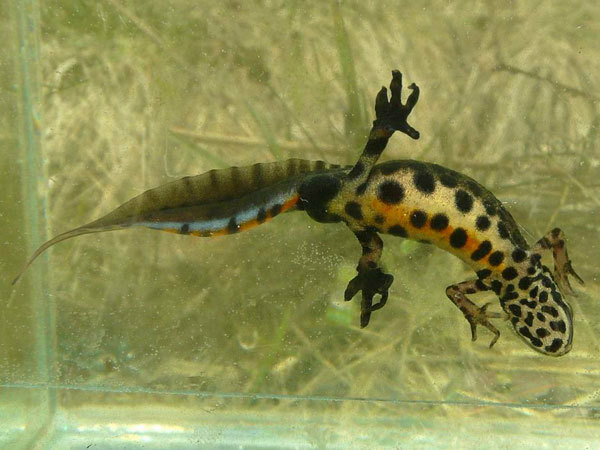

In [16]:
next(iter(ds))[0]